In [2]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import sys
import os
import os.path as path
import time
from tqdm import tqdm
from IPython.display import display, Video

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
parameters = {
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    'mathtext.default': 'it',
    'axes.labelsize': 26,
    'axes.titlesize': 26,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22
}
plt.rcParams.update(parameters)

# original library
import tbmodels as tb
from chebyshev_method import Chebyshev, gaussian, plane_wave

## Chebyshev expantion method

$$
\begin{align}
    \psi(t+\Delta t) \simeq e^{-ib\Delta t}\sum_{k}a_k(a\Delta t)T_k(-i\tilde{H})\psi(t). \tag{1}
\end{align}
$$

The coefficient of expansion $a_k$ are

$$
\begin{align}
    a_k(x) = \left\{
        \begin{array}{cc}
            J_0(x) & k=0\\
            2J_k(x) & k>0\\
        \end{array}
        \right., \tag{2}
\end{align}
$$

where the $J_k(x)$ are Bessel functions of the first kind.  
The $T_k$ represent Chebyshev polynomials.

$$
\begin{align}
    T_0(-i\tilde{H}) &= I,\\[6pt]
    T_1(-i\tilde{H}) &= -i\tilde{H} \tag{3},\\[6pt]
    T_k(-i\tilde{H}) &= -2i\tilde{H}T_{k-1}(-i\tilde{H}) + T_{k-2}(-i\tilde{H}).
\end{align}
$$

Since $T_k(x)$ is defined by $x\in[-1,1]$, we change the scale of the Hamiltonian.

$$
\begin{align}
    \tilde{H} = \frac{H-bI}{a} \tag{4},
\end{align}
$$

where $a$ and $b$ are

$$
\begin{align}
    a &= \frac{E_{\mathrm{max}} - E_{\mathrm{min}}}{2} + \epsilon,\\[8pt]
    b &= \frac{E_{\mathrm{max}} + E_{\mathrm{min}}}{2}. \tag{5}
\end{align}
$$

In [3]:
shape = 2048
x = np.arange(shape)
k0 = 2**-2
sigma = 50
x0 = shape*0.25
dt = 2.
Nt = 1024
H = tb.get_tight_binding_Hamiltonian(shape)
Psi = np.zeros((Nt,shape), dtype=np.complex128)
Psi[0] = gaussian(x, k0, x0, sigma)
ce = Chebyshev(H, dt, H_scale=2.)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Psi_real = np.real(Psi)

expansion order k = 11


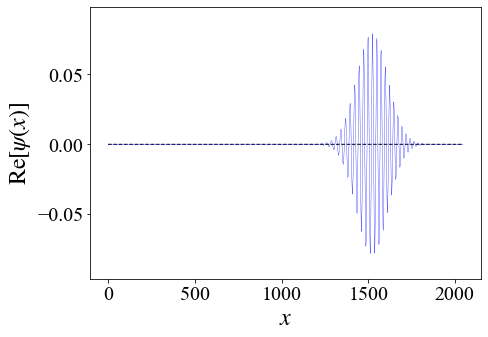

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,np.zeros_like(x), '--', color='black',markersize=10, linewidth =1, aa=True)
lines, = ax.plot(x,Psi_real[0], color='blue', linewidth =0.3)

anim = [] #アニメーション用に描くパラパラ図のデータを格納するためのリスト

def animate(i):
    lines.set_data(x,Psi_real[i])

anim = animation.FuncAnimation(fig, animate, frames=range(1,Nt,4)) # アニメーション作成  

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\mathrm{Re}[\psi(x)]$')

anim.save('movies/chebyshev1d_k0={:.3g}.mp4'.format(k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/chebyshev1d_k0={:.3g}.mp4'.format(k0))

## Direct Diagonalization

In [7]:
shape = 2048
x = np.arange(shape)
k0 = 2**-2
sigma = 50
x0 = shape*0.25
dt = 2.
Nt = 1024
H = tb.get_tight_binding_Hamiltonian(shape)
Psi = np.zeros((Nt,shape), dtype=np.complex128)
Psi[0] = gaussian(x, k0, x0, sigma)

energy, v = la.eigh(H.toarray())
vinv = la.inv(v)
coef = np.dot(vinv, Psi[0])

t_max = dt*(Nt-1)
t = np.linspace(0, t_max, Nt)
for i in tqdm(range(1,Nt)):
    Psi[i] = np.dot(v, coef*np.exp(-1j*energy*t[i]))
Psi_real = np.real(Psi)

100%|██████████| 1023/1023 [00:18<00:00, 55.34it/s]


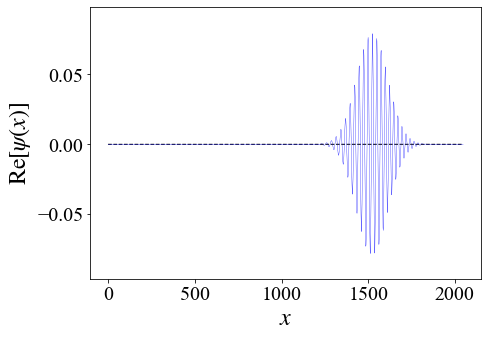

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,np.zeros_like(x), '--', color='black',markersize=10, linewidth =1, aa=True)
lines, = ax.plot(x,Psi_real[0], color='blue', linewidth =0.3)

anim = [] #アニメーション用に描くパラパラ図のデータを格納するためのリスト

def animate(i):
    lines.set_data(x,Psi_real[i])

anim = animation.FuncAnimation(fig, animate, frames=range(1,Nt,4)) # アニメーション作成  

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\mathrm{Re}[\psi(x)]$')

anim.save('movies/diagonalization1d_k0={:.3g}.mp4'.format(k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/diagonalization1d_k0={:.3g}.mp4'.format(k0))

## 2D

## Ando (S=1/2, Symplectic)

![ando](figures/Ando_band.png)

### $k_0 = 0$

In [9]:
t1 = np.sqrt(0.75)
t2 = 0.5
Lx = 1024
L = 16
shape = (Lx,L)
x, y = map(np.arange, shape)
X, Y = np.meshgrid(*[x,y], indexing='ij')
kx, ky = map(lambda n: np.linspace(-np.pi,np.pi,n+1)[:-1], shape)
KX, KY = np.meshgrid(*[kx,ky], indexing='ij')

k0 = 0.
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_Ando_Hamiltonian(shape, t1, t2)
Psi = np.zeros((Nt,2*np.prod(shape)), dtype=np.complex128)
Psi[0] = np.array([
    [gaussian(X, k0, x0, sigma)],
    [np.zeros_like(X)]
]).ravel()

def band_1(kx,ky,t1,t2,a=1.):
    return -2*t1 *(np.cos(kx*a) + np.cos(ky*a)) + 2*t2 *np.sqrt(np.sin(kx*a)**2 + np.sin(ky*a)**2)
E = band_1(KX,KY,t1,t2)
H_scale = np.max(E)
print('maximum eigenenergy = {:.4g}'.format(H_scale))
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

maximum eigenenergy = 3.742
expansion order k = 8


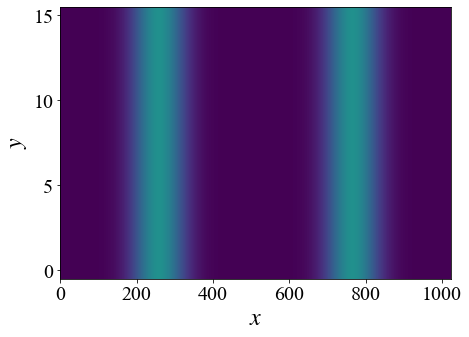

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X, Y, np.sum(Density[0].reshape(2,*shape),axis=0), shading='auto')

def animate(i):
    cax.set_array(np.sum(Density[i].reshape(2,*shape),axis=0))

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

### $k_0 = \pi/2$

In [2]:
t1 = np.sqrt(0.75)
t2 = 0.5
Lx = 1024
L = 16
shape = (Lx,L)
x, y = map(np.arange, shape)
X, Y = np.meshgrid(*[x,y], indexing='ij')
kx, ky = map(lambda n: np.linspace(-np.pi,np.pi,n+1)[:-1], shape)
KX, KY = np.meshgrid(*[kx,ky], indexing='ij')

k0 = np.pi*0.5
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_Ando_Hamiltonian(shape, t1, t2)
Psi = np.zeros((Nt,2*np.prod(shape)), dtype=np.complex128)
Psi[0] = np.array([
    [gaussian(X, k0, x0, sigma)],
    [np.zeros_like(X)]
]).ravel()

def band_1(kx,ky,t1,t2,a=1.):
    return -2*t1 *(np.cos(kx*a) + np.cos(ky*a)) + 2*t2 *np.sqrt(np.sin(kx*a)**2 + np.sin(ky*a)**2)
E = band_1(KX,KY,t1,t2)
H_scale = np.max(E)
print('maximum eigenenergy = {:.4g}'.format(H_scale))
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

maximum eigenenergy = 3.742
expansion order k = 8


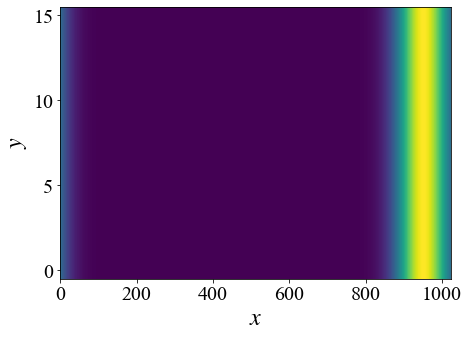

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X, Y, np.sum(Density[0].reshape(2,*shape),axis=0), shading='auto')

def animate(i):
    cax.set_array(np.sum(Density[i].reshape(2,*shape),axis=0))

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

### $k_0 = \tan^{-1}(t_2/t_1)$

In [4]:
t1 = np.sqrt(0.75)
t2 = 0.5
Lx = 1024
L = 16
shape = (Lx,L)
x, y = map(np.arange, shape)
X, Y = np.meshgrid(*[x,y], indexing='ij')
kx, ky = map(lambda n: np.linspace(-np.pi,np.pi,n+1)[:-1], shape)
KX, KY = np.meshgrid(*[kx,ky], indexing='ij')

k0 = np.arctan(t2/t1)
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_Ando_Hamiltonian(shape, t1, t2)
Psi = np.zeros((Nt,2*np.prod(shape)), dtype=np.complex128)
Psi[0] = np.array([
    [gaussian(X, k0, x0, sigma)],
    [np.zeros_like(X)]
]).ravel()

def band_1(kx,ky,t1,t2,a=1.):
    return -2*t1 *(np.cos(kx*a) + np.cos(ky*a)) + 2*t2 *np.sqrt(np.sin(kx*a)**2 + np.sin(ky*a)**2)
E = band_1(KX,KY,t1,t2)
H_scale = np.max(E)
print('maximum eigenenergy = {:.4g}'.format(H_scale))
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

maximum eigenenergy = 3.742
expansion order k = 8


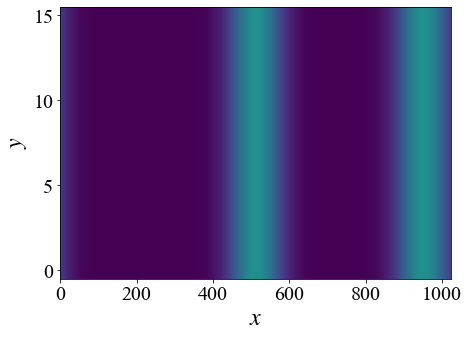

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X, Y, np.sum(Density[0].reshape(2,*shape),axis=0), shading='auto')

def animate(i):
    cax.set_array(np.sum(Density[i].reshape(2,*shape),axis=0))

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

### $k_0 = \frac12\tan^{-1}(t_2/t_1)$

In [15]:
t1 = np.sqrt(0.75)
t2 = 0.5
Lx = 1024
L = 16
shape = (Lx,L)
x, y = map(np.arange, shape)
X, Y = np.meshgrid(*[x,y], indexing='ij')
kx, ky = map(lambda n: np.linspace(-np.pi,np.pi,n+1)[:-1], shape)
KX, KY = np.meshgrid(*[kx,ky], indexing='ij')

k0 = np.arctan(t2/t1)*0.5
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_Ando_Hamiltonian(shape, t1, t2)
Psi = np.zeros((Nt,2*np.prod(shape)), dtype=np.complex128)
Psi[0] = np.array([
    [gaussian(X, k0, x0, sigma)],
    [np.zeros_like(X)]
]).ravel()

def band_1(kx,ky,t1,t2,a=1.):
    return -2*t1 *(np.cos(kx*a) + np.cos(ky*a)) + 2*t2 *np.sqrt(np.sin(kx*a)**2 + np.sin(ky*a)**2)
E = band_1(KX,KY,t1,t2)
H_scale = np.max(E)
print('maximum eigenenergy = {:.4g}'.format(H_scale))
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

maximum eigenenergy = 3.742
expansion order k = 8


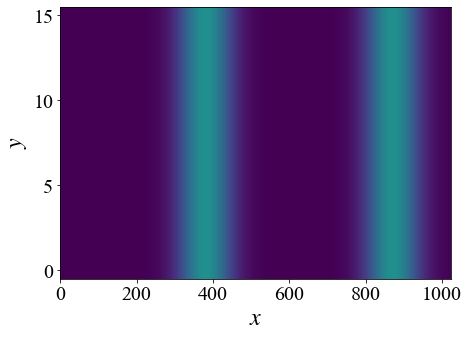

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X, Y, np.sum(Density[0].reshape(2,*shape),axis=0), shading='auto')

def animate(i):
    cax.set_array(np.sum(Density[i].reshape(2,*shape),axis=0))

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

## Ando (S=0 (=2D tight-binding), Orthogonal class)

![2dtb](figures/2d_tight_binding_band.png)

### $k0 = \pi/2$

In [17]:
t1 = 1.
t2 = 0.
Lx = 1024
L = 16
shape = (Lx,L)
x, y = map(np.arange, shape)
X, Y = np.meshgrid(*[x,y], indexing='ij')
kx, ky = map(lambda n: np.linspace(-np.pi,np.pi,n+1)[:-1], shape)
KX, KY = np.meshgrid(*[kx,ky], indexing='ij')

k0 = np.pi*0.5
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_Ando_Hamiltonian(shape, t1, t2)
Psi = np.zeros((Nt,2*np.prod(shape)), dtype=np.complex128)
Psi[0] = np.array([
    [gaussian(X, k0, x0, sigma)],
    [np.zeros_like(X)]
]).ravel()

def band_1(kx,ky,t1,t2,a=1.):
    return -2*t1 *(np.cos(kx*a) + np.cos(ky*a)) + 2*t2 *np.sqrt(np.sin(kx*a)**2 + np.sin(ky*a)**2)
E = band_1(KX,KY,t1,t2)
H_scale = np.max(E)
print('maximum eigenenergy = {:.4g}'.format(H_scale))
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in range(1,Nt):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

maximum eigenenergy = 4
expansion order k = 8


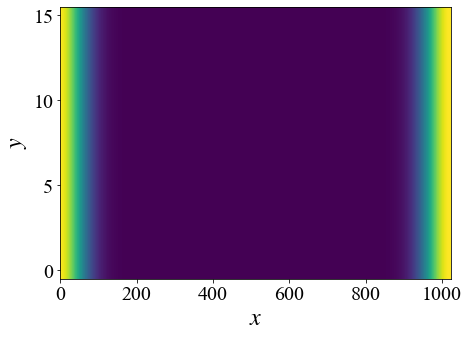

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X, Y, np.sum(Density[0].reshape(2,*shape),axis=0), shading='auto')

def animate(i):
    cax.set_array(np.sum(Density[i].reshape(2,*shape),axis=0))

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

## 3D orthogonal

![3dtb](figures/3d_tight_binding_band.png)

### $k_0=\pi/2$

In [19]:
Lx = 1024
L = 16
shape = (Lx,L,L)
x, y, z = map(np.arange, shape)
X, Y, Z = np.meshgrid(*[x,y,z], indexing='ij')

k0 = np.pi*0.5
sigma = 50
x0 = shape[0]*0.5

dt = 0.5
Nt = 512

H = tb.get_tight_binding_Hamiltonian(shape)
Psi = np.zeros((Nt,np.prod(shape)), dtype=np.complex128)
Psi[0] = gaussian(X, k0, x0, sigma).ravel()

H_scale = 6.
ce = Chebyshev(H, dt, H_scale=H_scale)

for i in tqdm(range(1,Nt)):
    Psi[i] = ce.apply_U(Psi[i-1])
    if i%10 == 0:
        Psi[i] /= la.norm(Psi[i])

Density = np.absolute(Psi)**2

expansion order k = 10


100%|██████████| 511/511 [00:51<00:00,  9.90it/s]


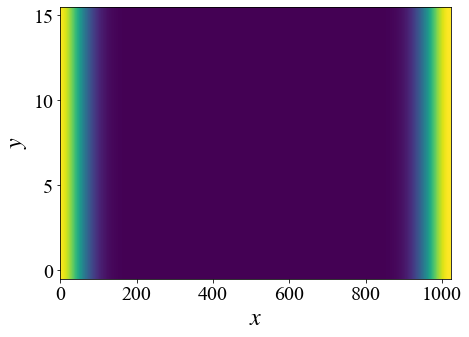

In [20]:
XX, YY = np.meshgrid(*[x,y], indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.pcolormesh(XX, YY, Density[0].reshape(*shape)[:,:,0], shading='auto')

def animate(i):
    cax.set_array(Density[i].reshape(*shape)[:,:,0])

anim = animation.FuncAnimation(fig, animate, frames=range(0,Nt,4))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

anim.save('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0), writer='ffmpeg', fps = int(Nt/32))
Video('movies/time_develop_Ando_S={:.1g}_k0={:.3g}.mp4'.format(t2,k0))

### Bessel function (1st kind)

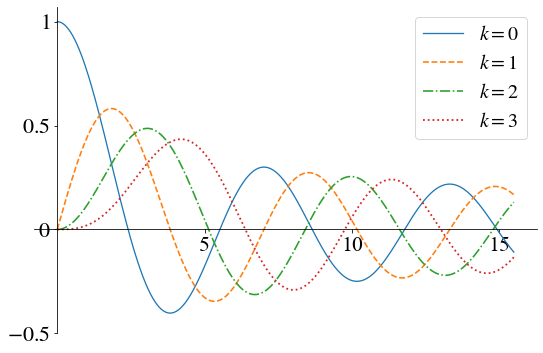

In [63]:
from scipy.special import jv

x = np.linspace(0,15.5,1000)

fig, ax = plt.subplots(figsize=(9,6))
linestyles = ["solid", "dashed", "dashdot", "dotted"]
linewidth = [1.3,1.6,1.6,1.8]
for i, (linestyle, w) in enumerate(zip(linestyles, linewidth)):
    y = jv(i,x)
    ax.plot(x,y, linestyle=linestyle, label='$k={}$'.format(i), linewidth=w)
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#ax.set_xlim(-1,None)
ax.set_ylim(-0.5,None)
ax.set_yticks([-0.5,0,0.5,1])
ax.legend(fontsize=20)
ax.set_xticks([5,10,15])
ax.set_yticks([-0.5,0,0.5,1])
ax.set_yticklabels([r"$-0.5$", r"$0$", r"$0.5$", r"$1$"])
plt.show()

### Chebyshev polynomials

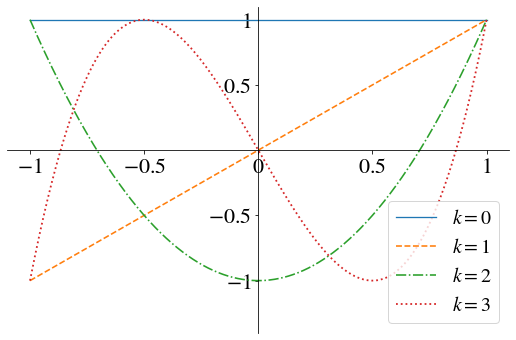

In [7]:
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt


# x座標データ
x = np.linspace(-1., 1., 1000)

fig, ax = plt.subplots(figsize=(9,6))
linestyles = ["solid", "dashed", "dashdot", "dotted"]
linewidth = [1.3,1.6,1.6,1.8]
for i, (linestyle, w) in enumerate(zip(linestyles, linewidth)):
    y = eval_chebyt(i, x)
    ax.plot(x,y, linestyle=linestyle, label='$k={}$'.format(i), linewidth=w)
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#ax.set_xlim(-1,None)
ax.set_ylim(-1.4,None)
ax.legend(fontsize=20)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0.5,1])
ax.set_xticklabels([r"$-1$", r"$-0.5$", r"$0$", r"$0.5$", r"$1$"])
ax.set_yticklabels([r"$-1$", r"$-0.5$", r"$0.5$", r"$1$"])
plt.show()